### Import bibliotek

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem 
from rdkit.Chem import Draw, AllChem, Descriptors

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scikitplot.estimators import plot_learning_curve, plot_feature_importances

from eli5.sklearn import PermutationImportance
import eli5

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

### Przygotowanie danych

In [98]:
df = pd.DataFrame()
for num in range(1,69):
    df_part = pd.read_csv("../input/data{}.csv".format(num), skiprows=0)
    df = pd.concat([df,df_part])
df_raw = df.rename(columns= {'SMILES':'smiles'})


### Wizualizacja z formatu smiles

In [99]:
smiles = 'O'
mol = Chem.MolFromSmiles(smiles)
type(mol)

rdkit.Chem.rdchem.Mol

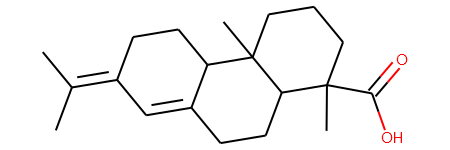

In [100]:
m1 = Chem.MolFromSmiles('CC(=C1CCC2C(=C1)CCC3C2(CCCC3(C)C(=O)O)C)C')
m1

### Informacje na temat struktury

In [101]:
m1.GetNumAtoms() #nie liczy atomów wodoru

22

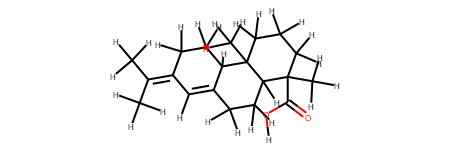

In [102]:
m = Chem.AddHs(m1)
m

In [103]:
m.GetNumAtoms() #liczy atomy wodoru

52

In [104]:
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

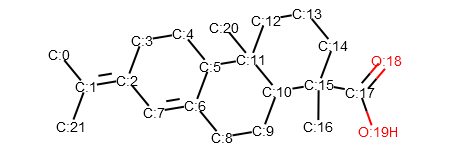

In [105]:
mol_with_atom_index(m1)

In [106]:
m.GetAtomWithIdx(11).GetSymbol()

'C'

In [107]:
m.GetAtomWithIdx(1).GetSymbol()

'C'

In [108]:
m.GetAtomWithIdx(8).GetSymbol()

'C'

In [109]:
for idx, atom in enumerate(m.GetAtoms()):
    print('index atomu:' , idx , '   symbol atomu:',atom.GetSymbol())

index atomu: 0    symbol atomu: C
index atomu: 1    symbol atomu: C
index atomu: 2    symbol atomu: C
index atomu: 3    symbol atomu: C
index atomu: 4    symbol atomu: C
index atomu: 5    symbol atomu: C
index atomu: 6    symbol atomu: C
index atomu: 7    symbol atomu: C
index atomu: 8    symbol atomu: C
index atomu: 9    symbol atomu: C
index atomu: 10    symbol atomu: C
index atomu: 11    symbol atomu: C
index atomu: 12    symbol atomu: C
index atomu: 13    symbol atomu: C
index atomu: 14    symbol atomu: C
index atomu: 15    symbol atomu: C
index atomu: 16    symbol atomu: C
index atomu: 17    symbol atomu: C
index atomu: 18    symbol atomu: O
index atomu: 19    symbol atomu: O
index atomu: 20    symbol atomu: C
index atomu: 21    symbol atomu: C
index atomu: 22    symbol atomu: H
index atomu: 23    symbol atomu: H
index atomu: 24    symbol atomu: H
index atomu: 25    symbol atomu: H
index atomu: 26    symbol atomu: H
index atomu: 27    symbol atomu: H
index atomu: 28    symbol atom

In [110]:
m.GetAtomWithIdx(11).GetExplicitValence()

4

In [111]:
m.GetAtomWithIdx(1).GetExplicitValence()

4

In [112]:
for idx, atom in enumerate(m.GetAtoms()):
    print('index atomu:' , idx , 
          '          symbol atomu:',atom.GetSymbol(), 
          '          liczba wiązań:', atom.GetExplicitValence() #walencyjność , liczba wiązań jakie może utworzyć atom z innymi atomami
)

index atomu: 0           symbol atomu: C           liczba wiązań: 4
index atomu: 1           symbol atomu: C           liczba wiązań: 4
index atomu: 2           symbol atomu: C           liczba wiązań: 4
index atomu: 3           symbol atomu: C           liczba wiązań: 4
index atomu: 4           symbol atomu: C           liczba wiązań: 4
index atomu: 5           symbol atomu: C           liczba wiązań: 4
index atomu: 6           symbol atomu: C           liczba wiązań: 4
index atomu: 7           symbol atomu: C           liczba wiązań: 4
index atomu: 8           symbol atomu: C           liczba wiązań: 4
index atomu: 9           symbol atomu: C           liczba wiązań: 4
index atomu: 10           symbol atomu: C           liczba wiązań: 4
index atomu: 11           symbol atomu: C           liczba wiązań: 4
index atomu: 12           symbol atomu: C           liczba wiązań: 4
index atomu: 13           symbol atomu: C           liczba wiązań: 4
index atomu: 14           symbol atomu: C   

In [113]:
m.GetBondWithIdx(5).GetBeginAtomIdx()

5

In [114]:
atom = m.GetAtomWithIdx(11)
for nei in atom.GetNeighbors():
    print("atom %s jest połączony z atomem %s poprzez %s wiązanie" % (atom.GetSymbol(), nei.GetSymbol(), m.GetBondBetweenAtoms(atom.GetIdx(), nei.GetIdx()).GetBondType()))

atom C jest połączony z atomem C poprzez SINGLE wiązanie
atom C jest połączony z atomem C poprzez SINGLE wiązanie
atom C jest połączony z atomem C poprzez SINGLE wiązanie
atom C jest połączony z atomem C poprzez SINGLE wiązanie


In [115]:
atom = m.GetAtomWithIdx(4)
for nei in atom.GetNeighbors():
    print("root atom %s is connected to %s by %s bond" % (atom.GetSymbol(), nei.GetSymbol(), m.GetBondBetweenAtoms(atom.GetIdx(), nei.GetIdx()).GetBondType()))

root atom C is connected to C by SINGLE bond
root atom C is connected to C by SINGLE bond
root atom C is connected to H by SINGLE bond
root atom C is connected to H by SINGLE bond


In [116]:
AllChem.ComputeGasteigerCharges(m)
for a in m.GetAtoms():
    print("atom %s o indeksie %i ma ładunek równy %f" % (a.GetSymbol(), a.GetIdx(), float(a.GetProp('_GasteigerCharge'))))
# Gasteiger charges sposób obliczenia wartości ładunku dla każdego atomu w cząsteczce

atom C o indeksie 0 ma ładunek równy -0.043627
atom C o indeksie 1 ma ładunek równy -0.073230
atom C o indeksie 2 ma ładunek równy -0.049383
atom C o indeksie 3 ma ładunek równy -0.027363
atom C o indeksie 4 ma ładunek równy -0.042081
atom C o indeksie 5 ma ładunek równy -0.013983
atom C o indeksie 6 ma ładunek równy -0.066263
atom C o indeksie 7 ma ładunek równy -0.059605
atom C o indeksie 8 ma ładunek równy -0.031088
atom C o indeksie 9 ma ładunek równy -0.045048
atom C o indeksie 10 ma ładunek równy -0.019196
atom C o indeksie 11 ma ładunek równy -0.022083
atom C o indeksie 12 ma ładunek równy -0.046949
atom C o indeksie 13 ma ładunek równy -0.051662
atom C o indeksie 14 ma ładunek równy -0.036990
atom C o indeksie 15 ma ładunek równy 0.068404
atom C o indeksie 16 ma ładunek równy -0.048759
atom C o indeksie 17 ma ładunek równy 0.309150
atom O o indeksie 18 ma ładunek równy -0.251812
atom O o indeksie 19 ma ładunek równy -0.480821
atom C o indeksie 20 ma ładunek równy -0.058766
atom

### Proste uczenie maszynowe
log(P) -  logarytm stosuneku stężeń substancji w dwóch niemieszających się rozpuszczalnikach w stanie równowagi

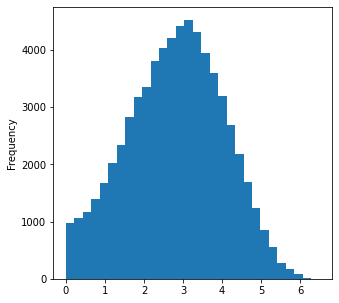

In [117]:
df_raw['logP'].plot(kind='hist', bins=30);

In [118]:
df = df_raw.copy()

In [119]:
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

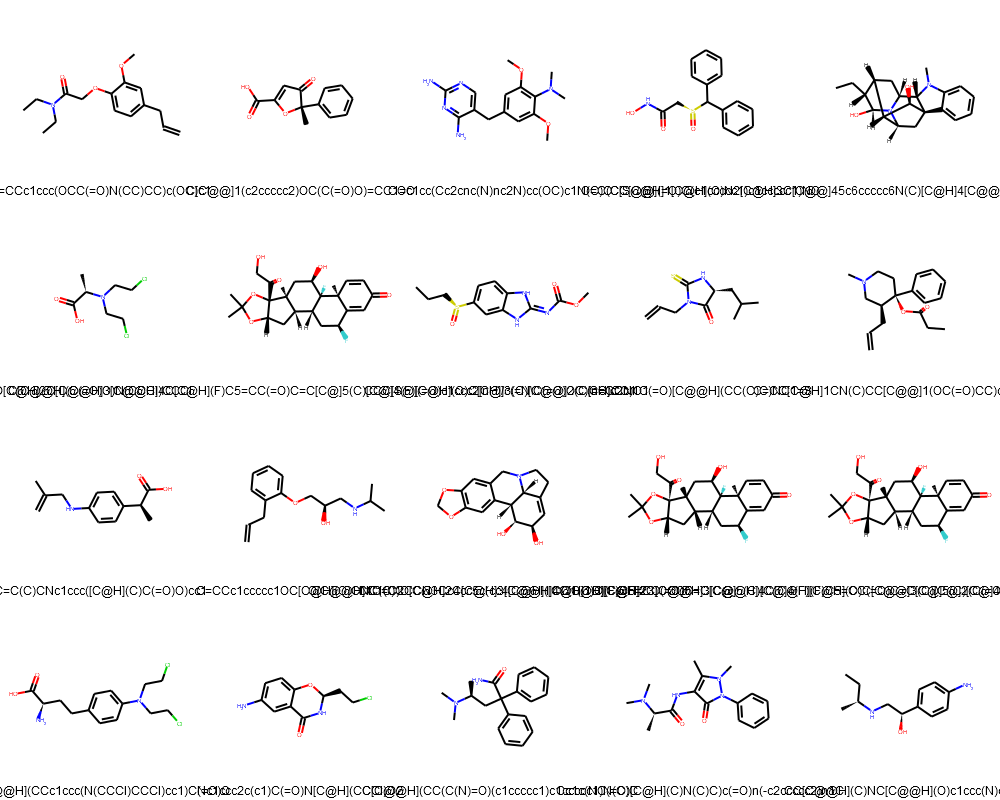

In [120]:
mols = df['mol'][:20]

Draw.MolsToGridImage(mols, molsPerRow=5, legends=list(df['smiles'][:20]))

In [121]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [122]:
df.head()

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1,2.671,<rdkit.Chem.rdchem.Mol object at 0x00000257025...,43,20
1,C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O,1.470,<rdkit.Chem.rdchem.Mol object at 0x00000257025...,26,16
2,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C,1.315,<rdkit.Chem.rdchem.Mol object at 0x0000025695C...,43,22
3,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,2.030,<rdkit.Chem.rdchem.Mol object at 0x0000025695C...,35,20
4,CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...,1.554,<rdkit.Chem.rdchem.Mol object at 0x0000025695C...,50,24


In [123]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

In [124]:
df.head()

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1,2.671,<rdkit.Chem.rdchem.Mol object at 0x00000257025...,43,20,16,3,1,0
1,C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O,1.470,<rdkit.Chem.rdchem.Mol object at 0x00000257025...,26,16,12,4,0,0
2,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C,1.315,<rdkit.Chem.rdchem.Mol object at 0x0000025695C...,43,22,15,2,5,0
3,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,2.030,<rdkit.Chem.rdchem.Mol object at 0x0000025695C...,35,20,15,3,1,0
4,CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...,1.554,<rdkit.Chem.rdchem.Mol object at 0x0000025695C...,50,24,20,2,2,0


In [125]:
def get_feats(df, black_list=['logP']):
    num_feats = df.select_dtypes(np.number).columns
    return [x for x in num_feats if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    X = df[feats].values
    y = df['logP'].values
    
    return X, y

def train_and_predict(model, X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=2016)
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    plt.hist(y_test - y_pred, bins=50);
    return mean_absolute_error(y_test, y_pred)

0.4480507007774009

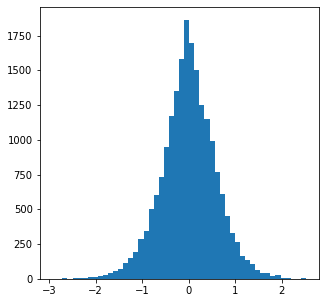

In [126]:
X, y = get_X_y(df)
train_and_predict(RandomForestRegressor(),X,y)

0.9944329614779365

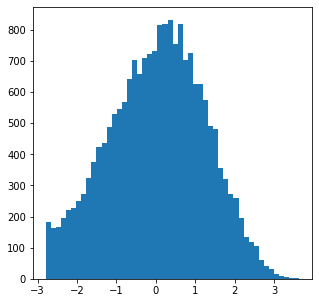

In [127]:
train_and_predict(DummyRegressor(),X,y)

0.45889283387173996

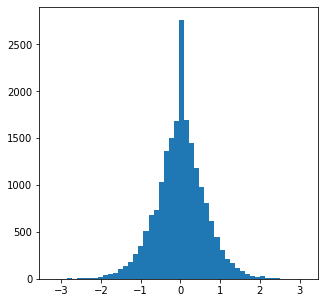

In [128]:
train_and_predict(DecisionTreeRegressor(),X,y)

0.44773505220764565

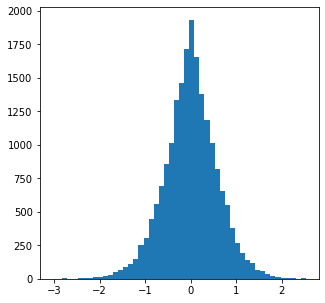

In [129]:
train_and_predict(RandomForestRegressor(),X,y)

0.4457202656650891

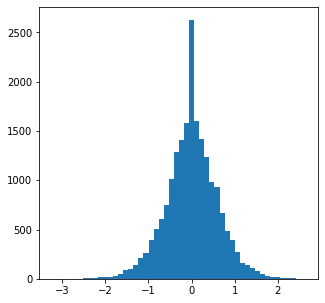

In [130]:
train_and_predict(ExtraTreesRegressor(),X,y)

In [131]:
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x)) #topological polar surface area, the sum of surfaces of polar atoms in a molecule
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x)) #molar mass
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
#df['FpDensityMorgan1'] = df['mol'].map(lambda x: Descriptors.FpDensityMorgan1(x))
#df['HeavyAtomMolWt'] = df['mol'].map(lambda x: Descriptors.HeavyAtomMolWt(x))

In [132]:
X,y = get_X_y(df)

0.9944329614779365

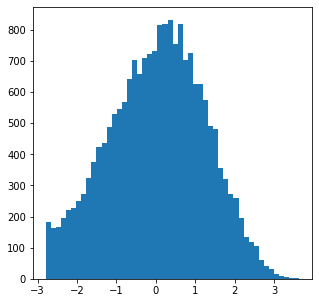

In [133]:
train_and_predict(DummyRegressor(),X,y)

0.43462065082290663

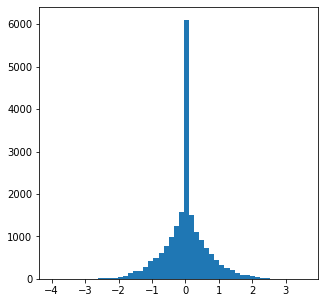

In [134]:
train_and_predict(DecisionTreeRegressor(),X,y)

0.37727337435849734

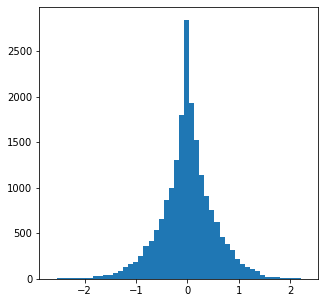

In [135]:
train_and_predict(RandomForestRegressor(),X,y)

0.3545380106060536

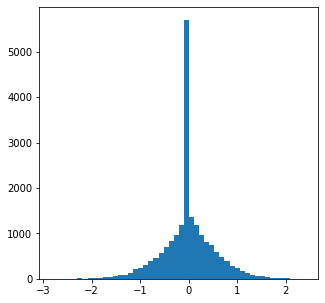

In [136]:
train_and_predict(ExtraTreesRegressor(),X,y)

0.4591749710569507

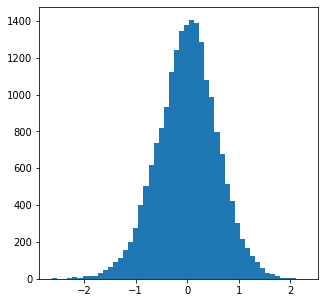

In [137]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=2018)
train_and_predict(model,X,y)

0.45939034503199055

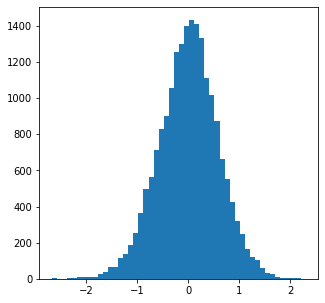

In [138]:
model = lgb.LGBMRegressor(n_estimators=100, random_state=2018, max_depth=3)
train_and_predict(model,X,y)

0.41287673713509904

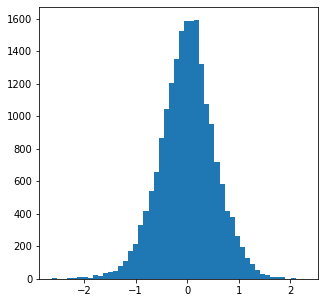

In [139]:
model = ctb.CatBoostRegressor(n_estimators=100, depth=5, random_state=2018, verbose=False)
train_and_predict(model,X,y)

### Perceptron wielowarstwowy

In [140]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
plt.rcParams['figure.figsize'] = (5,5)

In [141]:
model = Sequential([
    Dense(256, input_dim=10,activation='tanh'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2816      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 35,841
Trainable params: 35,841
Non-trainable params: 0
_________________________________________________________________


In [142]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
logP,65800.0,2.802680,1.221800,0.001000,1.938000,2.858000,3.689000,6.501000
num_of_atoms,65800.0,34.727462,7.722317,10.000000,30.000000,35.000000,40.000000,64.000000
num_of_heavy_atoms,65800.0,19.856125,3.764405,7.000000,18.000000,20.000000,23.000000,32.000000
num_of_C_atoms,65800.0,14.682614,3.577425,5.000000,12.000000,15.000000,17.000000,24.000000
num_of_O_atoms,65800.0,2.168374,1.408742,0.000000,1.000000,2.000000,3.000000,9.000000
num_of_N_atoms,65800.0,2.150198,1.387189,0.000000,1.000000,2.000000,3.000000,10.000000
num_of_Cl_atoms,65800.0,0.243891,0.565126,0.000000,0.000000,0.000000,0.000000,6.000000
tpsa,65800.0,58.726620,24.294988,0.000000,41.130000,56.240000,73.830000,150.000000
mol_w,65800.0,283.382856,49.351116,100.052429,253.058637,294.064057,323.173273,452.201045
num_valence_electrons,65800.0,102.996049,18.907111,36.000000,92.000000,106.000000,118.000000,176.000000


In [143]:
df_stats = df.describe().transpose().drop('logP')

def norm(x):
    return (x - df_stats['mean']) / df_stats['std']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2018)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2018)

model.fit(X_train, y_train,
          batch_size=1024, epochs=15, verbose=2,
          validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

Train on 46060 samples, validate on 19740 samples
Epoch 1/15
46060/46060 - 1s - loss: 1.1078 - val_loss: 0.7025
Epoch 2/15
46060/46060 - 1s - loss: 0.6366 - val_loss: 0.5668
Epoch 3/15
46060/46060 - 1s - loss: 0.5115 - val_loss: 0.4741
Epoch 4/15
46060/46060 - 1s - loss: 0.4397 - val_loss: 0.4115
Epoch 5/15
46060/46060 - 1s - loss: 0.3998 - val_loss: 0.4530
Epoch 6/15
46060/46060 - 0s - loss: 0.3927 - val_loss: 0.3706
Epoch 7/15
46060/46060 - 0s - loss: 0.3782 - val_loss: 0.3787
Epoch 8/15
46060/46060 - 0s - loss: 0.3569 - val_loss: 0.3506
Epoch 9/15
46060/46060 - 0s - loss: 0.3465 - val_loss: 0.3446
Epoch 10/15
46060/46060 - 0s - loss: 0.3479 - val_loss: 0.3467
Epoch 11/15
46060/46060 - 0s - loss: 0.3536 - val_loss: 0.3504
Epoch 12/15
46060/46060 - 0s - loss: 0.3418 - val_loss: 0.3392
Epoch 13/15
46060/46060 - 0s - loss: 0.3527 - val_loss: 0.3586
Epoch 14/15
46060/46060 - 0s - loss: 0.3401 - val_loss: 0.3370
Epoch 15/15
46060/46060 - 0s - loss: 0.3328 - val_loss: 0.3336


0.45518944611966616

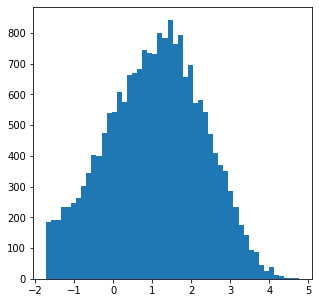

In [146]:
plt.hist(y_test - y_pred[0], bins=50);
mean_absolute_error(y_test, y_pred)

### Porównanie najlepszego modelu z danymi eksperymentalnymi i jego weryfikacja

In [184]:
def feats_eng(df):
    df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 
    df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
    #df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
    #df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
    df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x)) #topological polar surface area, the sum of surfaces of polar atoms in a molecule
    
    #df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x)) #molar mass
    #df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
    
    #df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
    #df['FpDensityMorgan1'] = df['mol'].map(lambda x: Descriptors.FpDensityMorgan1(x))
    
    df['HeavyAtomMolWt'] = df['mol'].map(lambda x: Descriptors.HeavyAtomMolWt(x))
    
    def number_of_atoms(atom_list, df):
        for i in atom_list:
            df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

    number_of_atoms(['C','O','N'], df)
    
    return df

In [185]:
df = df_raw.copy()
df = feats_eng(df)
X,y = get_X_y(df)

In [186]:
exp_data = {'smiles': ['C1=CC=C(C=C1)CO','C1=CC=C(C=C1)C=O','C1=CC=C(C=C1)C(=O)O','CC1=CC=CC=C1'], 
            'iupac': ['alkohol benzylowy','aldehyd benzoensowy','kwas benzoensowy','toluen']}

exp_data = pd.DataFrame(exp_data)
exp_data = feats_eng(exp_data)

feats = get_feats(exp_data)
        
X_exp = exp_data[feats].values
exp_data

,smiles,iupac,mol,tpsa,HeavyAtomMolWt,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms
0,C1=CC=C(C=C1)CO,alkohol benzylowy,<rdkit.Chem.rdchem.Mol object at 0x00000256F58...,20.23,100.076,7,1,0
1,C1=CC=C(C=C1)C=O,aldehyd benzoensowy,<rdkit.Chem.rdchem.Mol object at 0x00000256F58...,17.07,100.076,7,1,0
2,C1=CC=C(C=C1)C(=O)O,kwas benzoensowy,<rdkit.Chem.rdchem.Mol object at 0x00000256F58...,37.30,116.075,7,2,0
3,CC1=CC=CC=C1,toluen,<rdkit.Chem.rdchem.Mol object at 0x00000256F58...,0.00,84.077,7,0,0


In [187]:
cv = KFold(n_splits=3)
model = ExtraTreesRegressor(random_state=2018)

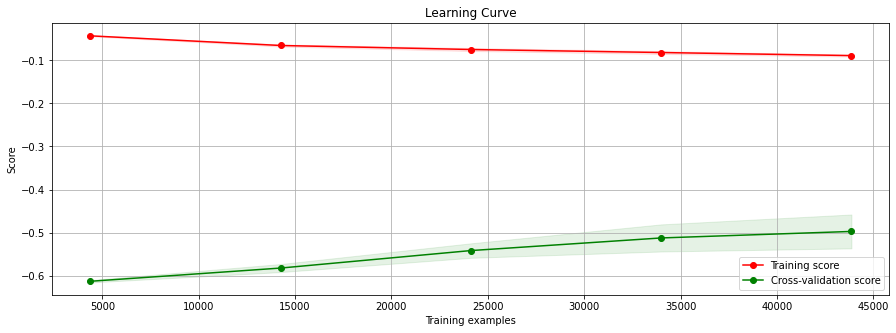

In [188]:
plot_learning_curve(model,X,y,figsize=(15, 5),cv=cv, random_state=2018,scoring='neg_mean_absolute_error')

Krzywe nie zbiegają się do siebie więc model sobie świetnie radzi na treningowym zestawie natomiast na validacyjnym dużo gorzej, co świadczy o przeuczeniu się modelu. Pomimo to spróbójmy porównać wynik

In [189]:
feats = get_feats(df)
model.fit(X, y)
perm = PermutationImportance(model, random_state=0).fit(X, y)
eli5.show_weights(perm, feature_names=feats)

Weight,Feature
0.6278 ± 0.0072,num_of_C_atoms
0.5353 ± 0.0073,num_of_O_atoms
0.5069 ± 0.0015,num_of_N_atoms
0.4738 ± 0.0053,HeavyAtomMolWt
0.4245 ± 0.0030,tpsa


In [190]:
model = ExtraTreesRegressor()
model.fit(X, y)
y_pred = model.predict(X_exp)

In [191]:
y_pred

array([1.07685, 1.3592 , 1.339  , 1.6652 ])

In [192]:
exp_data['logP_pred'] = y_pred

In [193]:
exp_data[['iupac','logP_pred']].sort_values(by='logP_pred')

,iupac,logP_pred
0,alkohol benzylowy,1.07685
2,kwas benzoensowy,1.33900
1,aldehyd benzoensowy,1.35920
3,toluen,1.66520


Pomimo wyraźnie słabej jakości modelu (plot_learning_curve) kolejność przewidywanych logP zgodne z poniższym chromatogramem. Kolejność czasu retencji taka sama jak kolejność posortowanych i przewidzianych logP

![](../input/chrom.png)